# 시도할 것들
- input normalization 비교 (v) 
- batchnormalize
- dropout
- dense layer 개수 및 dimension (v)

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Activation, LayerNormalization, BatchNormalization, Dropout
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, activations

from sklearn.metrics import classification_report

In [1]:
# 구글 드라이브 마운트
root_dir = '/content/drive/MyDrive/데싸개_기말플젝'

In [14]:
!rm -r /content/images/interior

In [15]:
%cd /content/
!pwd

!mkdir ./images
%cd ./images

/content
/content
mkdir: cannot create directory ‘./images’: File exists
/content/images


In [3]:
!tar -zxvf '/content/drive/My Drive/데싸개_기말플젝/images.tar.gz' -C '/content/images' 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
images/food16448.jpg
images/interior1131.jpg
images/food17756.jpg
images/interior6886.jpg
images/food18465.jpg
images/interior13003.jpg
images/interior7540.jpg
images/exterior2926.jpg
images/food10039.jpg
images/interior8673.jpg
images/food13530.jpg
images/exterior7686.jpg
images/interior4049.jpg
images/interior3726.jpg
images/food8296.jpg
images/exterior9873.jpg
images/interior2438.jpg
images/interior11614.jpg
images/food15141.jpg
images/food9188.jpg
images/interior994.jpg
images/exterior6598.jpg
images/interior5357.jpg
images/food12148.jpg
images/interior5431.jpg
images/interior11172.jpg
images/exterior1591.jpg
images/food15627.jpg
images/interior3040.jpg
images/food14539.jpg
images/food13256.jpg
images/food9836.jpg
images/interior7226.jpg
images/interior8115.jpg
images/exterior3386.jpg
images/food17030.jpg
images/food2963.jpg
images/interior13765.jpg
images/food18303.jpg
images/exterior2098.jpg
images/interior1657.jpg
images/food10987.jpg
images/i

In [16]:
!mv ./images ./images_raw
!mkdir ./images

mv: cannot stat './images': No such file or directory


In [ ]:
# !rm ./images_raw/exterior -r
# !rm ./images_raw/food -r
# !rm ./images_raw/interior -r

In [20]:
# 데이터 디렉토리 형태를 image_dataset_from_directory에 맞는 형태로 바꾼다
def preprocess_datadir(data_dir, target_dir):
    import re
    from shutil import copyfile

    # 디렉토리 검사 및 생성해놓기
    labels = ['food', 'interior', 'exterior']
    if not os.path.isdir(os.path.join(os.getcwd(), target_dir)):
        os.mkdir(os.path.join(os.getcwd(), target_dir))
        print("target directory : {} 생성 완료!".format(target_dir))
    for label in labels:
        if not os.path.isdir(os.path.join(target_dir, label)):
            os.mkdir(os.path.join(target_dir, label))
            print("sub directory : {} 생성 완료!".format(label))

    # raw data 디렉토리에는 모든 데이터가 한번에 들어있다
    # data_dir: ./data_dir/foodxxx.jpg
    # target_dir: ./target_dir/food/foodxxx.jpg
    for i, file in enumerate(os.listdir(data_dir)):
        pattern = re.compile('[^0-9]')
        name = "".join(pattern.findall(file.split('.jpg')[0]))
        sub_dir = None
        if name == labels[0]: # food
            sub_dir = os.path.join(os.getcwd(), target_dir, labels[0])
        elif name == labels[1]: # interior
            sub_dir = os.path.join(os.getcwd(), target_dir, labels[1])
        elif name == labels[2]: # exterior
            sub_dir = os.path.join(os.getcwd(), target_dir, labels[2])

        if sub_dir is not None:
            src = os.path.join(data_dir, file)
            trg = os.path.join(sub_dir, file)
            copyfile(src, trg)
            print("file: {} 처리 완료".format(file))

        if i % 1000 == 0:
            print("{} 번째 처리 완료.".format(i))



# batch단위로 나뉜 train, validation data 얻기
def get_data(data_dir, train:bool):
    # 참고
    # https://www.tensorflow.org/tutorials/load_data/images
    # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

    batch_size = 256
    height, width = 300, 300
    class_names = ['food', 'interior', 'exterior']
    normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255)

    if train == True:
        train_dataset = image_dataset_from_directory(
            data_dir,
            validation_split=0.1,
            subset='training',
            shuffle=True,
            labels='inferred',
            label_mode='categorical',
            class_names=class_names,
            seed=42,
            image_size=(height, width),
            batch_size=batch_size
        )
        # # Normalize
        # train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
        return train_dataset
    else:
        val_dataset = image_dataset_from_directory(
            data_dir,
            validation_split=0.1,
            subset='validation',
            shuffle=True,
            labels='inferred',
            label_mode='categorical',
            class_names=class_names,
            seed=41,
            image_size=(height, width),
            batch_size=batch_size
        )
        # # Normalize
        # val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
        return val_dataset


def show_image(array):
    plt.show(array, cmap='gray')


def history_from_text(path):
    f = open(path, 'r')
    loss, val_loss = [], []
    accuracy, val_accuracy = [], []

    line = f.readline()
    while True:
        line = f.readline()
        if not line: break
        ls, val_ls, acc, val_acc = line.split('\t')

        loss.append(float(ls))
        val_loss.append(float(val_ls))
        accuracy.append(float(acc))
        val_accuracy.append(float(val_acc))
    f.close()

    history = {'loss':loss, 'val_loss':val_loss, 'accuracy':accuracy, 'val_accuracy':val_accuracy}
    return history


def plot_curve(history):
    # summarize history for accuracy
    epochs = [i+1 for i in range(len(history['accuracy']))]
    plt.plot(epochs, history['accuracy'])
    plt.plot(epochs, history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(epochs, history['loss'])
    plt.plot(epochs, history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [22]:
def train_model(train_loader, val_loader, model_path):

    # Model
    # # model1
    # model = Sequential([
    # Input(shape=(300, 300, 3), name='input_layer'),
    # Conv2D(32, kernel_size=5, activation='relu', name='conv_layer1'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(128, kernel_size=5, activation='relu', name='conv_layer2'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(512, kernel_size=3, activation='relu', name='conv_layer3'),
    # MaxPooling2D(pool_size=2),
    # Flatten(),
    # Dense(3, activation='softmax', name='output_layer')
    # ])

    # # model2
    # model = Sequential([
    # Input(shape=(300, 300, 3), name='input_layer'),
    # # LayerNormalization(), # channel에서 normalize
    # Conv2D(16, kernel_size=5, strides=2, activation='relu', name='conv_layer1'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(32, kernel_size=5, strides=2, activation='relu', name='conv_layer2'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(64, kernel_size=3, strides=1, activation='relu', name='conv_layer3'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(128, kernel_size=3, strides=1, activation='relu', name='conv_layer4'),
    # MaxPooling2D(pool_size=2),
    # Flatten(),
    # # Dense(128, activation='relu', name='hidden_layer'),
    # Dense(3, activation='softmax', name='output_layer')
    # ])

    # model3
    model = Sequential([
    Input(shape=(300, 300, 3), name='input_layer'),
    # LayerNormalization(), # channel에서 normalize
    Conv2D(16, kernel_size=5, strides=1, activation='relu', name='conv_layer1'),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=5, strides=1, activation='relu', name='conv_layer2'),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=5, strides=1, activation='relu', name='conv_layer3'),
    MaxPooling2D(pool_size=2),
    Conv2D(128, kernel_size=3, strides=1, activation='relu', name='conv_layer4'),
    MaxPooling2D(pool_size=2),
    Conv2D(256, kernel_size=3, strides=1, activation='relu', name='conv_layer5'),
    MaxPooling2D(pool_size=2),
    Conv2D(512, kernel_size=3, strides=1, activation='relu', name='conv_layer6'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(3, activation='softmax', name='output_layer')
    ])

    # # model3.3
    # model = Sequential([
    # Input(shape=(300, 300, 3), name='input_layer'),
    # # LayerNormalization(), # channel에서 normalize

    # # Convolution layer 1
    # Conv2D(16, kernel_size=5, strides=1, name='conv_layer1'),
    # BatchNormalization(),
    # Activation(activations.relu),
    # Dropout(rate=0.2),
    # MaxPooling2D(pool_size=2),
    
    # # Convolution layer 2
    # Conv2D(32, kernel_size=5, strides=1, name='conv_layer2'),
    # BatchNormalization(),
    # Activation(activations.relu),
    # Dropout(rate=0.2),
    # MaxPooling2D(pool_size=2),
    
    # # Convolution layer 3
    # Conv2D(64, kernel_size=5, strides=1, name='conv_layer3'),
    # BatchNormalization(),
    # Activation(activations.relu),
    # Dropout(rate=0.2),
    # MaxPooling2D(pool_size=2),
    
    # # Convolution layer 4
    # Conv2D(128, kernel_size=3, strides=1, name='conv_layer4'),
    # BatchNormalization(),
    # Activation(activations.relu),
    # Dropout(rate=0.2),
    # MaxPooling2D(pool_size=2),
    
    # # Convolution layer 5
    # Conv2D(256, kernel_size=3, strides=1, name='conv_layer5'),
    # BatchNormalization(),
    # Activation(activations.relu),
    # Dropout(rate=0.2),
    # MaxPooling2D(pool_size=2),
    
    # # Convolution layer 6
    # Conv2D(512, kernel_size=3, strides=1, name='conv_layer6'),
    # BatchNormalization(),
    # Activation(activations.relu),
    # Dropout(rate=0.2),
    # MaxPooling2D(pool_size=2),
    
    # # FC layer
    # Flatten(),
    # Dense(3, activation='softmax', name='output_layer')
    # ])

    # # model4
    # model = Sequential([
    # Input(shape=(300, 300, 3), name='input_layer'),
    # Conv2D(16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv_layer1'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(32, kernel_size=5, strides=1, padding='same', activation='relu', name='conv_layer2'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(64, kernel_size=4, strides=1, padding='same', activation='relu', name='conv_layer3'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu', name='conv_layer4'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(256, kernel_size=3, strides=1, activation='relu', name='conv_layer5'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(300, kernel_size=2, strides=1, activation='relu', name='conv_layer6'),
    # MaxPooling2D(pool_size=2),
    # Conv2D(400, kernel_size=2, strides=1, activation='relu', name='conv_layer7'),
    # MaxPooling2D(pool_size=2),
    # Flatten(),
    # Dense(3, activation='softmax', name='output_layer')
    # ])

    model.summary()


    # log_dir = os.path.join(os.getcwd(), model_name)
    # if not os.path.isdir(log_dir):
    #     os.mkdir(log_dir)
    # tensorboard = TensorBoard(log_dir=log_dir)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training
    history = model.fit(train_loader, validation_data=val_loader, batch_size=256, epochs=40) #, callbacks=[tensorboard])
    print(history.history)
    print("train loss=", history.history['loss'][-1])
    print("validation loss=", history.history['val_loss'][-1])


    # Plot training loss
    plot_curve(history.history)

    # Save model
    model.save(model_path)
    print("model save 완료!")

    # Save loss, accuracy info
    ret = 'loss' + '\t' + 'val_loss' + '\t' + 'accuracy' + '\t' + 'val_accuarcy' + '\n'
    for i in range(len(history.history['loss'])):
        ret += str(history.history['loss'][i]) + '\t'
        ret += str(history.history['val_loss'][i]) + '\t'
        ret += str(history.history['accuracy'][i]) + '\t'
        ret += str(history.history['val_accuracy'][i]) + '\n'
    with open(model_path+'.txt', "a") as lossfile:
        lossfile.write(ret)
    print("loss, accuracy 파일 저장 완료!")


    return model

In [9]:
from sklearn.metrics import classification_report

def predict_test(model_dir, val_loader):

    # Load trained model
    model = load_model(model_dir)
    
    idx2label = {0:'food', 1:'interior', 2:'exterior'}
    # key=label, value=predict(uncorrect)
    uncorrect_label = {'food':[], 'interior':[], 'exterior':[]}
    uncorrect_image = {'food':[], 'interior':[], 'exterior':[]}
    correct_label = {'food':[], 'interior':[], 'exterior':[]}
    correct_image = {'food':[], 'interior':[], 'exterior':[]}
    
    label = []
    predict = []
    
    # Predict test data
    for image_batch, label_batch in val_loader:
        for i in range(len(image_batch)):
            image, lb = image_batch[i], label_batch[i]
            test_image = np.array(image)
            test_image = test_image.reshape((1, 300, 300, 3))
            pred = model.predict(test_image/255.0)
            
            lb = np.argmax(np.array(lb), axis=0)
            pred = np.argmax(pred, axis=1)[0]
            label.append(lb)
            predict.append(pred)
            
            if lb != pred and len(uncorrect_label[idx2label[lb]]) < 2 :
                uncorrect_label[idx2label[lb]].append(pred)
                uncorrect_image[idx2label[lb]].append(image)
                
            if lb == pred and len(correct_label[idx2label[lb]]) < 2 :
                correct_label[idx2label[lb]].append(pred)
                correct_image[idx2label[lb]].append(image)

        
    # Classification report: accuracy, precision, recall, f1-score
    target_names = ['food', 'interior', 'exterior']
    print(classification_report(label, predict, target_names=target_names))
    
    
    # Visualize wrong predict
    fig, axs = plt.subplots(6, 2, figsize=(15, 50))

    
    for col, lb in enumerate(correct_label):
        for row, image in enumerate(correct_image[lb]):
            pr = correct_label[lb][row]
            pr_label = idx2label[pr]
            axs[col, row].imshow(image/255.0)
            axs[col, row].text(15, 20, "LABEL:{}, PREDICT: {}".format(lb, pr_label), 
                               bbox={'facecolor': 'white', 'pad': 8})
    
    for col, lb in enumerate(uncorrect_label):
        for row, image in enumerate(uncorrect_image[lb]):
            pr = uncorrect_label[lb][row]
            pr_label = idx2label[pr]
            axs[col+3, row].imshow(image/255.0)
            axs[col+3, row].text(15, 20, "LABEL:{}, PREDICT: {}".format(lb, pr_label), 
                               bbox={'facecolor': 'white', 'pad': 8})

    plt.show()
    
    return uncorrect_label, uncorrect_image, correct_label, correct_image

In [ ]:
if __name__ == "__main__":

    # 1. 학습을 위해 데이터 위치(디렉토리)를 전처리한다.
    # 학습데이터 위치: 현재 디렉토리/images/
    raw_dir = os.path.join(os.getcwd(), 'images_raw')
    target_dir = os.path.join(os.getcwd(), 'images')
    preprocess_datadir(raw_dir, target_dir)

    # data loader
    data_dir = os.path.join('/content/images', 'images') # = target_dir
    train_data = get_data(data_dir, True)
    val_data = get_data(data_dir, False)
    # for image_batch, labels_batch in train_data:
    #     print(image_batch.shape)
    #     print(labels_batch.shape)
    #     print(image_batch[0])
    #     print(np.max(image_batch[0]))
    #     break
    # for image_batch, labels_batch in val_data:
    #     print(image_batch.shape)
    #     print(labels_batch.shape)
    #     print(image_batch[0])
    #     print(np.max(image_batch[0]))
    #     break

    # 2. Training
    root_dir = '/content/drive/My Drive/데싸개_기말플젝'
    model_name = 'model-201711719'
    model_path = os.path.join(root_dir, model_name)

    start = time.time()
    train_model(train_data, val_data, model_path)
    end = time.time()
    print("학습 시간: {} 초".format(end-start))

    # # # 3. Test
    # # model_dir = './model3.model'
    # # predict_test(model_dir, val_data)

Found 45000 files belonging to 3 classes.
Using 31500 files for training.
Found 45000 files belonging to 3 classes.
Using 13500 files for validation.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 300, 300, 3)       6         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 296, 296, 16)      1216      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 148, 148, 16)      0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 144, 144, 32)      12832     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 72, 72, 32)        0         
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 

In [5]:
if __name__ == "__main__":

    # # 1. 학습을 위해 데이터 위치(디렉토리)를 전처리한다.
    # # 학습데이터 위치: 현재 디렉토리/images/
    # raw_dir = os.path.join(os.getcwd(), 'images_raw')
    # target_dir = os.path.join(os.getcwd(), 'images')
    # preprocess_datadir(raw_dir, target_dir)

    # data loader
    data_dir = os.path.join('/content/images', 'images') # = target_dir
    train_data = get_data(data_dir, True)
    val_data = get_data(data_dir, False)
    # for image_batch, labels_batch in train_data:
    #     print(image_batch.shape)
    #     print(labels_batch.shape)
    #     print(image_batch[0])
    #     print(np.max(image_batch[0]))
    #     break
    # for image_batch, labels_batch in val_data:
    #     print(image_batch.shape)
    #     print(labels_batch.shape)
    #     print(image_batch[0])
    #     print(np.max(image_batch[0]))
    #     break

    # 2. Training
    root_dir = '/content/drive/My Drive/데싸개_기말플젝'
    model_name = 'model-201711719'
    model_path = os.path.join(root_dir, model_name)

    start = time.time()
    train_model(train_data, val_data, model_path)
    end = time.time()
    print("학습 시간: {} 초".format(end-start))

    # # # 3. Test
    # # model_dir = './model3.model'
    # # predict_test(model_dir, val_data)

Found 45000 files belonging to 3 classes.
Using 40500 files for training.
Found 45000 files belonging to 3 classes.
Using 4500 files for validation.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization (LayerNo (None, 300, 300, 3)       6         
_________________________________________________________________
conv_layer1 (Conv2D)         (None, 296, 296, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 16)      0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 144, 144, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 68,

InvalidArgumentError: ignored

Found 45000 files belonging to 3 classes.
Using 40500 files for training.
Found 45000 files belonging to 3 classes.
Using 4500 files for validation.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 296, 296, 16)      1216      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 148, 148, 16)      0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 144, 144, 32)      12832     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 72, 72, 32)        0         
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 68, 68, 64)        51264     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 3

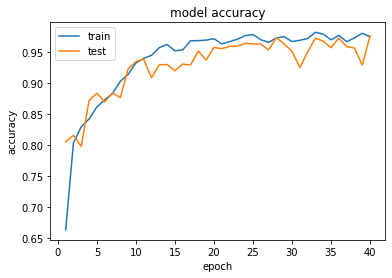

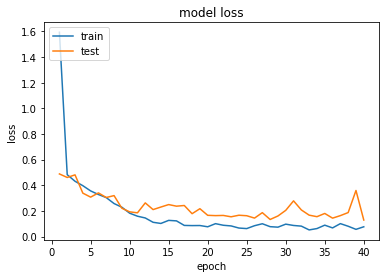

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/데싸개_기말플젝/model-201711719/assets
model save 완료!
loss, accuracy 파일 저장 완료!
학습 시간: 8822.379293680191 초


In [23]:
# # 1. 학습을 위해 데이터 위치(디렉토리)를 전처리한다.
# # 학습데이터 위치: 현재 디렉토리/images/
# raw_dir = os.path.join(os.getcwd(), 'images_raw')
# target_dir = os.path.join(os.getcwd(), 'images')
# preprocess_datadir(raw_dir, target_dir)

# data loader
data_dir = os.path.join('/content/images', 'images') # = target_dir
train_data = get_data(data_dir, True)
val_data = get_data(data_dir, False)
# for image_batch, labels_batch in train_data:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     print(image_batch[0])
#     print(np.max(image_batch[0]))
#     break
# for image_batch, labels_batch in val_data:
#     print(image_batch.shape)
#     print(labels_batch.shape)
#     print(image_batch[0])
#     print(np.max(image_batch[0]))
#     break

# 2. Training
root_dir = '/content/drive/My Drive/데싸개_기말플젝'
model_name = 'model-201711719'
model_path = os.path.join(root_dir, model_name)

start = time.time()
train_model(train_data, val_data, model_path)
end = time.time()
print("학습 시간: {} 초".format(end-start))